In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('Book1.csv')
df

,Dates,Sales
0,06/04/2020,657.50
1,06/05/2020,522.50
2,06/06/2020,1823.75
3,06/07/2020,2342.25
4,06/08/2020,378.50
...,...,...
1726,02/24/2025,1854.50
1727,02/25/2025,1944.00
1728,02/26/2025,2188.50
1729,02/27/2025,1588.75


In [4]:
df['Sales'].fillna(0, inplace = True)
print("\nMissing values after filling:")
print(df.isnull().sum())


Missing values after filling:
Dates    0
Sales    0
dtype: int64


In [8]:
df['Dates'] = pd.to_datetime(df['Dates'])

# Set the Date column as the index (if it is not already)
df.set_index('Dates', inplace=True)

KeyError: 'Dates'

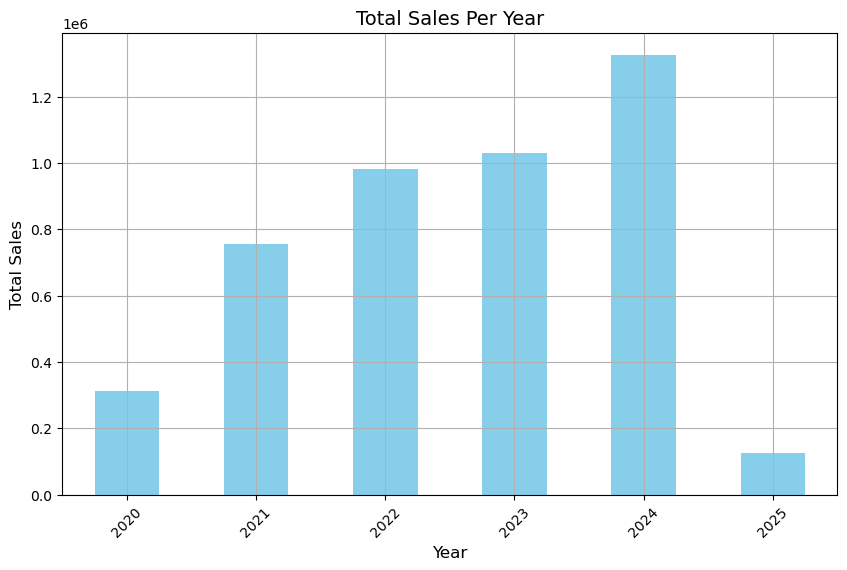

In [9]:
df['Year'] = df.index.year
sales_per_year = df.groupby('Year')['Sales'].sum()  # Use 'sum' to get total sales per year

# Plot the total sales per year
plt.figure(figsize=(10, 6))
sales_per_year.plot(kind='bar', color='skyblue')
plt.title('Total Sales Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

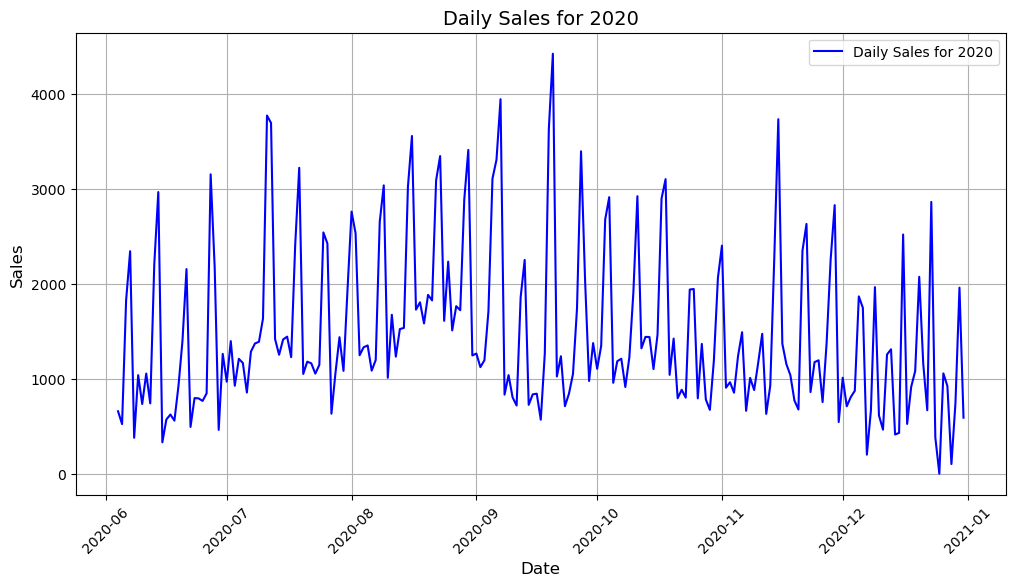

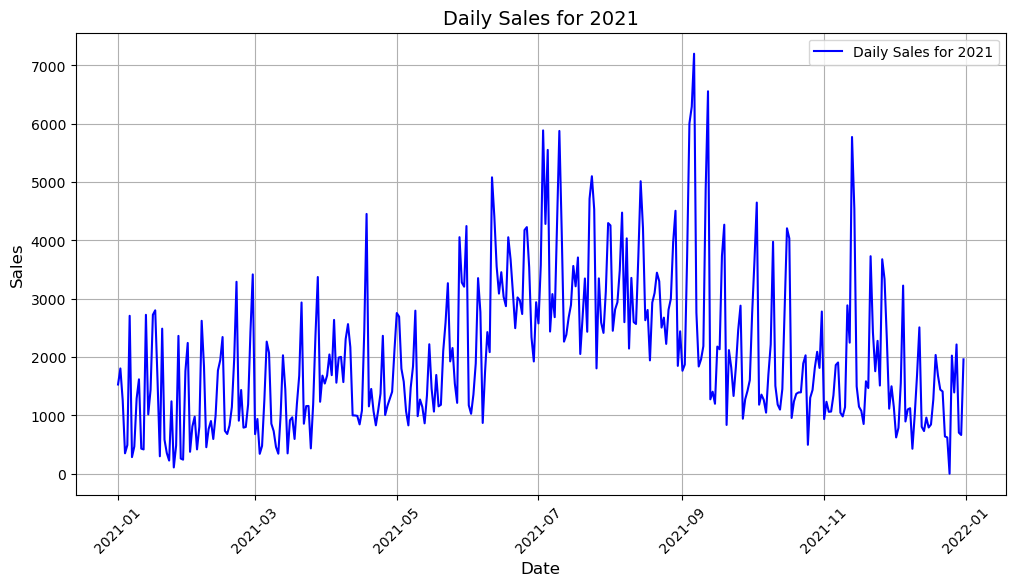

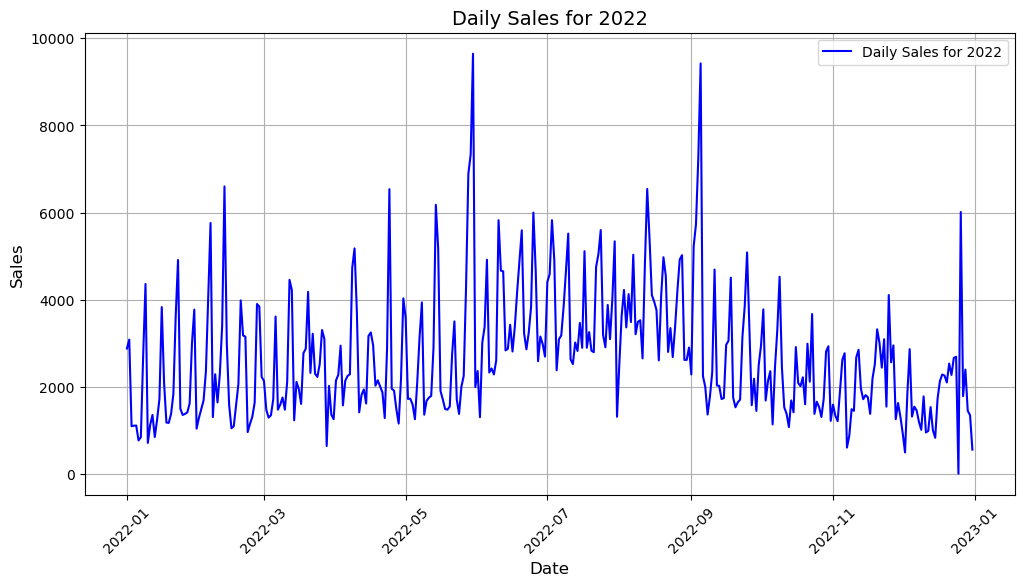

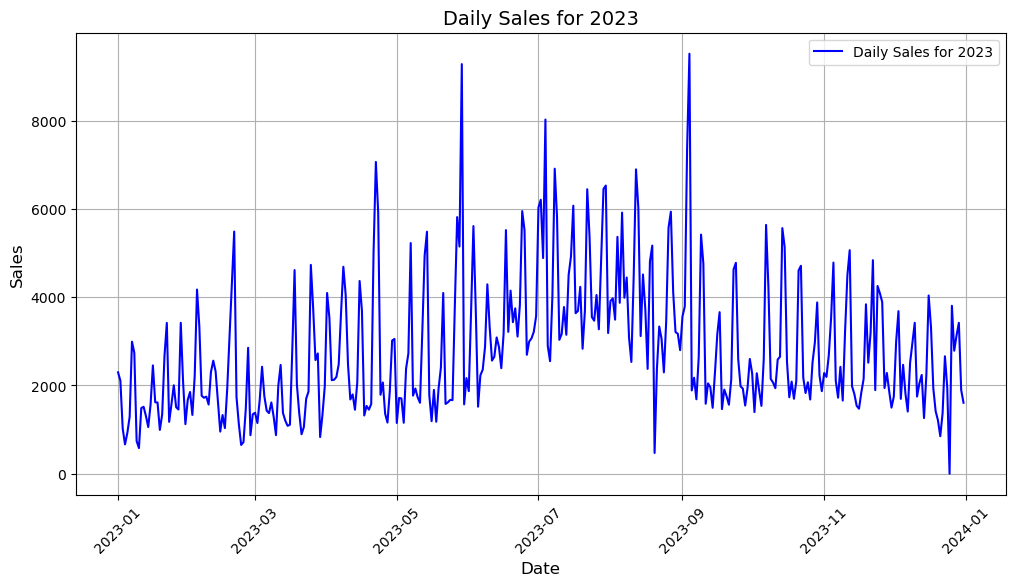

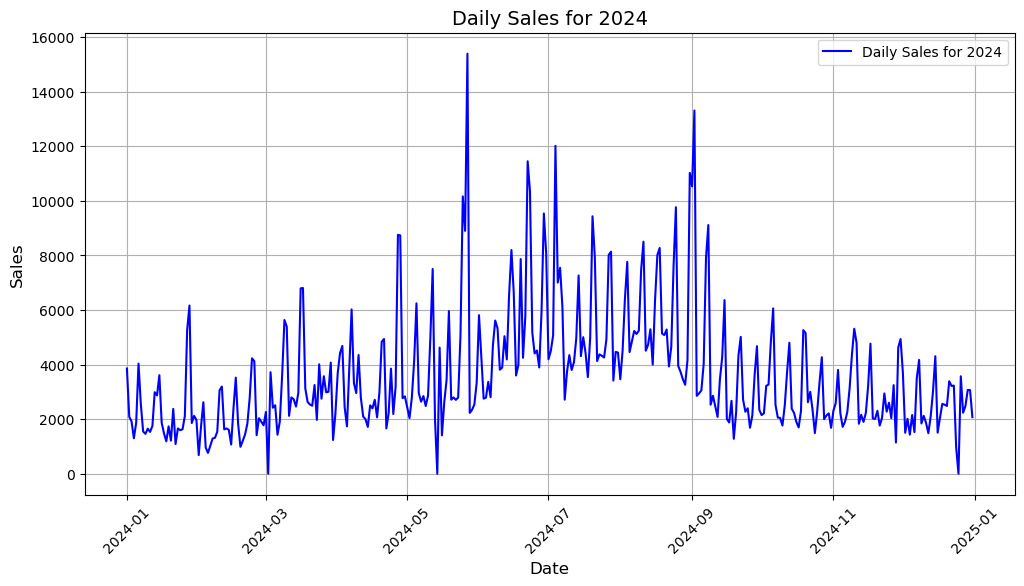

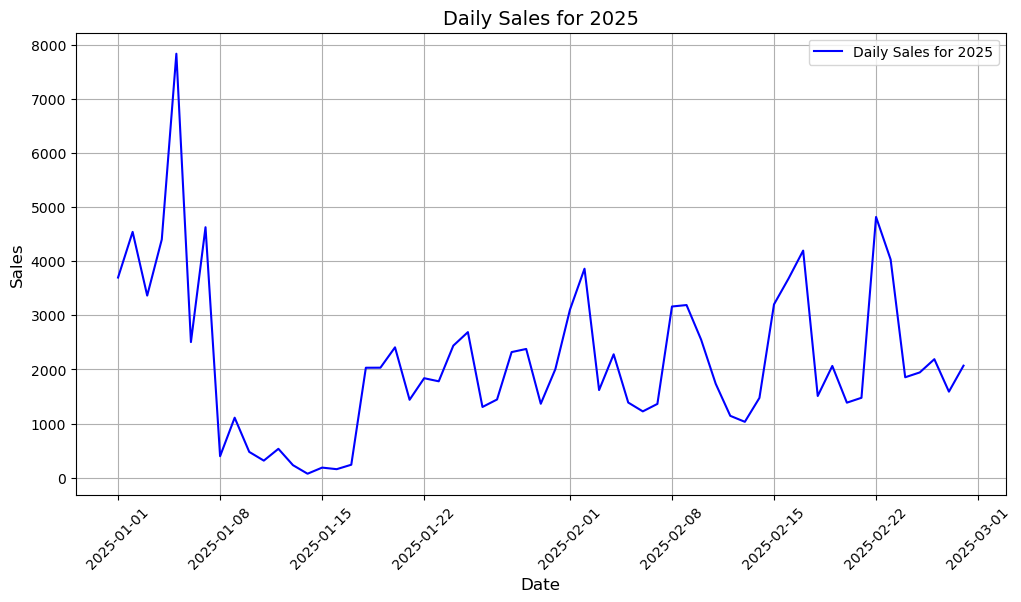

In [11]:
df['Year'] = df.index.year

# Get unique years from the data
years = df['Year'].unique()

# Create a separate plot for each year
for year in years:
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    
    # Create a new figure for the current year
    plt.figure(figsize=(12, 6))
    
    # Plot the daily sales for the current year
    plt.plot(year_data.index, year_data['Sales'], label=f'Daily Sales for {year}', color='blue')
    
    # Customize the plot
    plt.title(f'Daily Sales for {year}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot for the current year
    plt.show()

In [18]:
train = df[df.index.year <= 2024]
test = df[df.index.year == 2025]

result = adfuller(train['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
train['Sales_diff'] = train['Sales'].diff().dropna()
result = adfuller(train['Sales_diff'].dropna())
print('ADF Statistic on Differenced Data:', result[0])
print('p-value on Differenced Data:', result[1])

ADF Statistic: -2.733238831827973
p-value: 0.06846098339061865
ADF Statistic on Differenced Data: -13.15414631282447
p-value on Differenced Data: 1.3480104932525582e-24


/var/folders/m9/f14vh3qn1zvgdpsvs0qydbxh0000gn/T/ipykernel_32086/226555538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sales_diff'] = train['Sales'].diff().dropna()


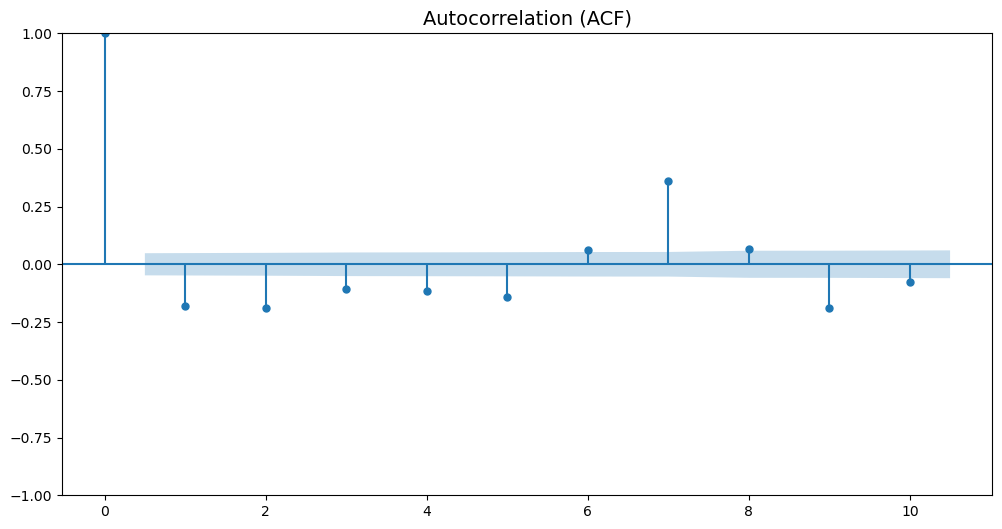

In [24]:
plt.figure(figsize=(12, 6))
plot_acf(train['Sales_diff'].dropna(), lags=10, ax=plt.gca())
plt.title('Autocorrelation (ACF)', fontsize=14)
plt.show()

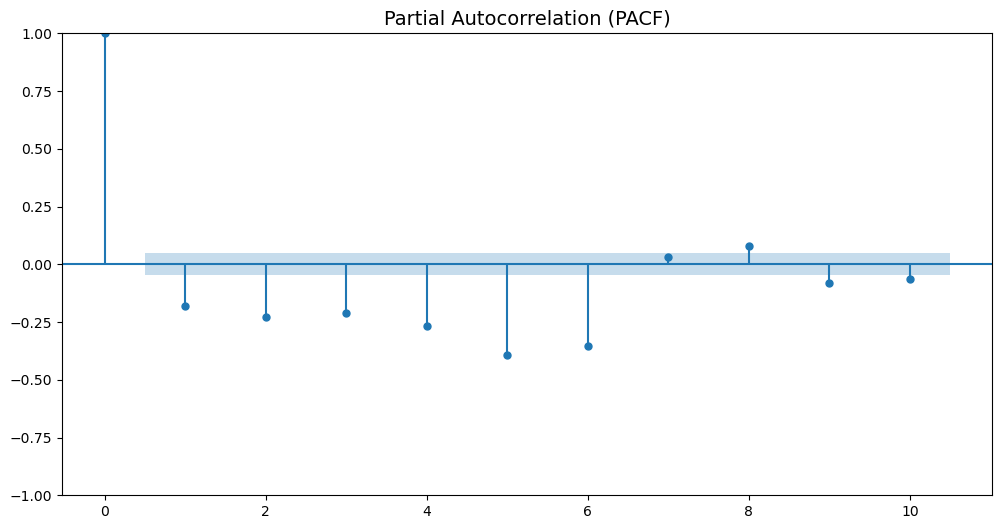

In [23]:
plt.figure(figsize=(12, 6))
plot_pacf(train['Sales_diff'].dropna(), lags=10, ax=plt.gca())
plt.title('Partial Autocorrelation (PACF)', fontsize=14)
plt.show()

/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels

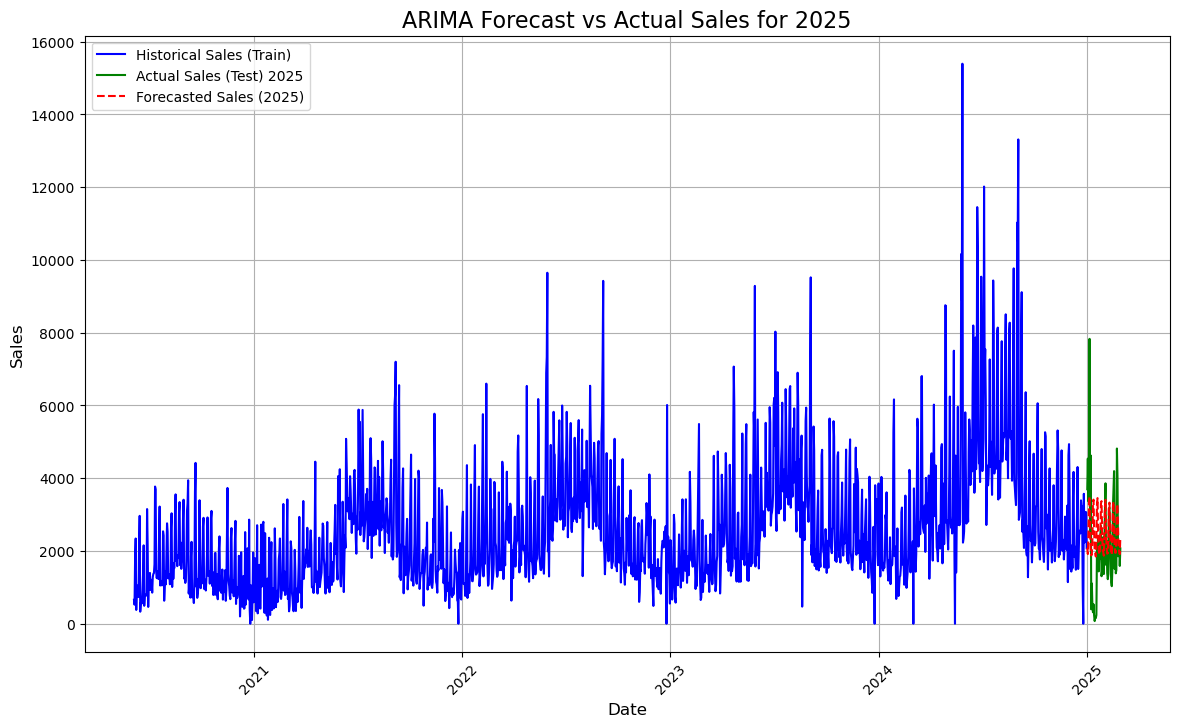

R-squared (R²) on the test set: 0.1282
                 Date  Predicted_Sales
2025-01-01 2025-01-01      2086.045967
2025-01-02 2025-01-02      1915.384000
2025-01-03 2025-01-03      2394.669179
2025-01-04 2025-01-04      3308.750736
2025-01-05 2025-01-05      3497.943336
2025-01-06 2025-01-06      2529.283385
2025-01-07 2025-01-07      2012.810707
2025-01-08 2025-01-08      1876.546424
2025-01-09 2025-01-09      1906.392319
2025-01-10 2025-01-10      2314.682869


In [32]:
# Step 1: Fit ARIMA model on the training data (up to 2024)
model = ARIMA(train['Sales'], order=(9, 1, 6))
model_fit = model.fit()

# Step 2: Forecast for the next 365 days (2025)
forecast_steps = len(test)  # Forecast steps are the same as the test data length
forecast = model_fit.forecast(steps=forecast_steps)

# Step 3: Create a DataFrame for the forecasted sales
forecast_df = pd.DataFrame({'Date': test.index, 'Predicted_Sales': forecast})

# Step 4: Plot historical, test, and predicted sales
plt.figure(figsize=(14, 8))
plt.plot(train.index, train['Sales'], label='Historical Sales (Train)', color='blue')
plt.plot(test.index, test['Sales'], label='Actual Sales (Test) 2025', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Sales'], label='Forecasted Sales (2025)', color='red', linestyle='--')
plt.title('ARIMA Forecast vs Actual Sales for 2025', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Step 5: Calculate R-squared (R²) to evaluate model performance
r2 = r2_score(test['Sales'], forecast)
print(f'R-squared (R²) on the test set: {r2:.4f}')

# Optional: Print out the forecasted sales for the first few days of 2025
print(forecast_df.head(10))

In [ ]:
model = SARIMAX(train['Sales'], order=(9, 1, 6), seasonal_order=(9, 1, 6, 365))  # Adjust as needed
model_fit = model.fit()

# Step 2: Forecast for the next 365 days (2025)
forecast_steps = len(test)  # Forecast steps are the same as the test data length
forecast = model_fit.forecast(steps=forecast_steps)

# Step 3: Create a DataFrame for the forecasted sales
forecast_df = pd.DataFrame({'Date': test.index, 'Predicted_Sales': forecast})

# Step 4: Plot historical, test, and predicted sales
plt.figure(figsize=(14, 8))
plt.plot(train.index, train['Sales'], label='Historical Sales (Train)', color='blue')
plt.plot(test.index, test['Sales'], label='Actual Sales (Test) 2025', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Sales'], label='Forecasted Sales (2025)', color='red', linestyle='--')
plt.title('SARIMA Forecast vs Actual Sales for 2025', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Step 5: Calculate R-squared (R²) to evaluate model performance
r2 = r2_score(test['Sales'], forecast)
print(f'R-squared (R²) on the test set: {r2:.4f}')

# Optional: Print out the forecasted sales for the first few days of 2025
print(forecast_df.head(10))

/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/shreyagarwal/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/shreyagarwal/anaconda3/lib/python3